In this post I will show how to make [Grantland type shot charts](https://www.google.com/search?q=grantland+shot+chart&newwindow=1&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiH7fqBs9_TAhUKslQKHXNdDOEQ_AUIDCgD&biw=1536&bih=686#imgrc=PtFvtiAvmijqYM:) with Python. 

The basic idea of the shot chart is:
* Shots are represented by hexagons
* More shots = larger hexagon and vice versa
* Color of the hexagon represents the FG % relative to the league average. The FG % is done in zones not per spot (due to lack of statistics in each spot)

In [1]:
import pandas as pd
import NBAapi as nba
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import urllib, cStringIO
from scipy import misc

%matplotlib inline

I'm going to create a new function that accepts X and Y coordiantes and returns a tuple with the shot zome. This will be used later.

In [2]:
def shot_zone(X,Y):
    '''
    Uses shot coordinates x and y (in feet - divide by 10 if using the shotchart units)
    and returns a tuple with the zone location
    '''
    r = np.sqrt(X**2+Y**2)
    a = np.arctan2(Y,X)*180.0/np.pi
    if (Y<0) & (X > 0):
        a = 0
    elif (Y<0) & (X < 0):
        a = 180
    if r<=8:
        z = ('Less Than 8 ft.','Center(C)')
    elif (r>8) & (r<=16):
        if a < 60:
            z = ('8-16 ft.','Right Side(R)')
        elif (a>=60) & (a<=120):
            z = ('8-16 ft.','Center(C)')
        else:
            z = ('8-16 ft.','Left Side(L)')
    elif (r>16) & (r<=23.75):
        if a < 36:
            z = ('16-24 ft.','Right Side(R)')
        elif (a>=36) & (a<72):
            z = ('16-24 ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('16-24 ft.','Center(C)')
        elif (a>108) & (a<144):
            z = ('16-24 ft.','Left Side Center(LC)')
        else:
            z = ('16-24 ft.','Left Side(L)')
    elif r>23.75:
        if a < 72:
            z = ('24+ ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('24+ ft.','Center(C)')
        else:
            z = ('24+ ft.','Left Side Center(LC)')
    if (np.abs(X)>=22):
        if (X > 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Right Side(R)')
        elif (X < 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Left Side(L)')
        elif (X > 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Right Side Center(RC)')
        elif (X < 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Left Side Center(LC)')
    if Y >= 40:
        z = ('Back Court Shot', 'Back Court(BC)')
    return z

This function returns a players picture base on their player ID:

In [3]:
def players_picture(player_id):
    '''
    Input: player ID
    Output: players picture
    '''
    URL = "http://stats.nba.com/media/players/230x185/%d.png" %player_id
    file = cStringIO.StringIO(urllib.urlopen(URL).read())
    return misc.imread(file)

First, let's load a list of all NBA players using the commonallplayers function:

In [4]:
player_list = nba.player.commonallplayers(currentseason=0) # load a list of NBA players including retired players 
player_list.head()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
0,76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,,,,,Y
1,76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,,,,,Y
2,76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,,,,,Y
3,51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,mahmoud_abdul-rauf,0,,,,,Y
4,1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,,,,,Y


We need to create a DataFrame with the FG% per zone for the entire league and for the player we are interested in:

In [5]:
player_name = 'James, LeBron' # identify player by name
player_id = player_list[player_list['DISPLAY_LAST_COMMA_FIRST']== player_name].PERSON_ID # get players id

# get shotchart for the player and the league average
shotchart,leagueavergae = nba.shotchart.shotchartdetail(playerid=player_id,season='2016-17') 

# league average output contains more zones than we need. Let's reduce the it to the information we need
LA = leagueavergae.loc[:,'SHOT_ZONE_AREA':'FGM'].groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA']).sum()
LA['FGP'] = 1.0*LA['FGM']/LA['FGA'] # create new column with FG%

# get statistics per zone for the player from the shot chart information
player = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
# create new column with FG%
player['FGP'] = 1.0*player.loc[:,1]/player.sum(axis=1)

We are going to use the hexbin histogram from matplotlib to get the shot frequency and use the counts and bin vertices to reconstruct the plot: 

In [6]:
player_vs_league = (player.loc[:,'FGP'] - LA.loc[:,'FGP'])*100 # compares player's FG% to league average
x,y = 0.1*shotchart.LOC_X.values, 0.1*shotchart.LOC_Y.values # get players shot coordinates

# get heetxbin to do the hard work for us. Use the extent and gridsize to get the desired bins
poly_hexbins = plt.hexbin(x,y, gridsize=35, extent=[-25,25,-6.25,50-6.25])

# get counts and vertices from histogram
counts = poly_hexbins.get_array()
verts = poly_hexbins.get_offsets()

# close figure since we are not interested in it
plt.close()

Here is how the player's FG% vs. league looks like (in this case LeBron's):

In [7]:
np.round(player_vs_league,1)

SHOT_ZONE_RANGE  SHOT_ZONE_AREA       
16-24 ft.        Center(C)                -5.3
                 Left Side Center(LC)    -17.5
                 Left Side(L)            -10.0
                 Right Side Center(RC)     1.1
                 Right Side(R)           -13.4
24+ ft.          Center(C)                11.2
                 Left Side Center(LC)     -1.2
                 Left Side(L)              4.9
                 Right Side Center(RC)    -0.9
                 Right Side(R)            -9.4
8-16 ft.         Center(C)                 0.4
                 Left Side(L)              1.4
                 Right Side(R)            -4.0
Back Court Shot  Back Court(BC)           -2.5
Less Than 8 ft.  Center(C)                15.3
Name: FGP, dtype: float64

We are ready to plot:

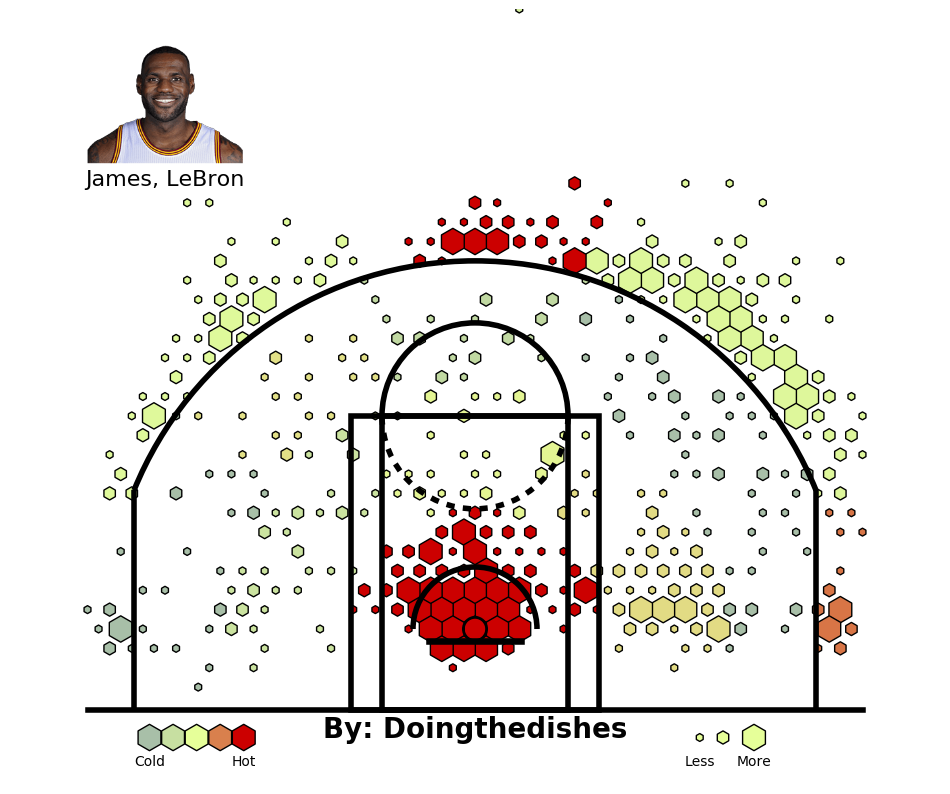

In [8]:
# create figure plot
plt.figure(figsize=(12,10),facecolor='white') 
ax = plt.gca(xlim = [30,-30],ylim = [-10,40],xticks=[],yticks=[],aspect=1.0)
plt.text(0,-7,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
nba.plot.court(ax,outer_lines=False,color='black',lw=4.0,direction='down')
ax.axis('off')
 
s = 0.85 # scaling factor for hexagons

# FG% bins from -9 to 9. I'm using 200 bins to make the color scale more continous. This is my personal preference. 
# I think that this is not the case with the Grantland shot charts
bins = np.concatenate([[-np.inf],np.linspace(-9,9,200),[np.inf]]) 

# choose color scheme. I choose colors that are similar to the ones in Grantland
colors = [(0.66, 0.75, 0.66),(0.9,1.0,0.6), (0.8, 0, 0)]
cm = LinearSegmentedColormap.from_list('my_list', colors, N=len(bins)-1) # create linear color scheme

# create hexagons
xy = s*np.array([np.cos(np.linspace(np.pi/6,np.pi*330/180,6)),np.sin(np.linspace(np.pi/6,np.pi*330/180,6))]).T
b = np.zeros((6,2))
# adjust size scaling factor depending on the frequency of shots. Size-frequency relationship was choosen empirically 
counts_norm = np.zeros_like(counts)
counts_norm[counts>=4] = 1 # 4 shots or more= full size hexagon
counts_norm[(counts>=2) & (counts<4)] = 0.5 # 2 or 3 shots = half size hexagon 
counts_norm[(counts>=1) & (counts<2)] = 0.3 # 1 shot = small hexagon

# start creating patch and color list
patches=[]
colors=[]
# loop over vertices
for offc in xrange(verts.shape[0]):
    if counts_norm[offc] != 0:
        xc,yc = verts[offc][0],verts[offc][1] # vertex center 
        b[:,0] = xy[:,0]*counts_norm[offc] + xc # hexagon x coordinates
        b[:,1] = xy[:,1]*counts_norm[offc] + yc # hexagon y coordinates
        p_diff = player_vs_league.loc[shot_zone(xc,yc)] # FG% difference for the specific zone
        inds = np.digitize(p_diff, bins,right=True)-1 # convert FG% difference to color index  
        patches.append(Polygon(b))
        colors.append(inds)

# create colorbar 
for i in range(5):
    xc = 21-2*0.76*i
    yc = -7
    b[:,0] = xy[:,0] + xc
    b[:,1] = xy[:,1] + yc
    patches.append(Polygon(b))
    colors.append(i*50)
plt.text(21,-8.5,'Cold',horizontalalignment='center',verticalalignment='center')
plt.text(21-2*0.76*4,-8.5,'Hot',horizontalalignment='center',verticalalignment='center')

# create frequency illustration
xc = -14.5
yc = -7.0
plt.text(xc,-8.5,'Less',horizontalalignment='center',verticalalignment='center')
b[:,0] = xy[:,0]*0.3 + xc
b[:,1] = xy[:,1]*0.3 + yc
patches.append(Polygon(b))
colors.append(100)
xc = -16
b[:,0] = xy[:,0]*0.50 + xc
b[:,1] = xy[:,1]*0.50 + yc
patches.append(Polygon(b))
colors.append(100)
xc = -18
b[:,0] = xy[:,0] + xc
b[:,1] = xy[:,1] + yc
plt.text(xc,-8.5,'More',horizontalalignment='center',verticalalignment='center')

patches.append(Polygon(b))
colors.append(100)

# plot all patches
p = PatchCollection(patches,cmap=cm,alpha=1)
p.set_array(np.array(colors))
ax.add_collection(p)
p.set_clim([0, len(bins)-1])

# include player's picture
pic = players_picture(player_id)
plt.imshow(pic,extent=[15,25,30,37.8261])
plt.text(20,29,player_name,fontsize=16,horizontalalignment='center',verticalalignment='center')

I created a function - NBAapi.plot.grantland_shotchart that includes all of the code above.


## Shot chart over time
I would like to check a player's shot chart evolution over time so let's create a function that returns a list of seasons based on starting and ending years 

In [9]:
def seasons_string(start,end):
    '''
    creates a list of NBA seasons from start-end
    '''
    years = np.arange(start,end+1)
    seasons = []
    for year in years:
        string1 = str(year)
        string2 = str(year+1)
        season = '{}-{}'.format(string1,string2[-2:])
        seasons.append(season)
    return seasons

## Interactive Shotchart
We can use the ipywidgets to get interactive plotting in Jupyter Notebook

In [10]:
from ipywidgets import interact

# Plotting 
player_name = 'Curry, Stephen'
player_id = player_list[player_list['DISPLAY_LAST_COMMA_FIRST']== player_name].PERSON_ID # get players id
 
# create season string based on the seasons Steph Curry played in the league
seasons = seasons_string(player_list[player_list['DISPLAY_LAST_COMMA_FIRST']== player_name].FROM_YEAR.astype(int),
                        player_list[player_list['DISPLAY_LAST_COMMA_FIRST']== player_name].TO_YEAR.astype(int))

# interactive plotting
def browse_images(seasons):
    def update_plot(Season):
        shotchart,leagueavergae = nba.shotchart.shotchartdetail(playerid=player_id,season=Season) # get shot chart data from NBA.stats
        nba.plot.grantland_shotchart(shotchart,leagueavergae)
        plt.text(0,38,Season,fontsize=20,horizontalalignment='center',verticalalignment='center')
        plt.show()
    interact(update_plot,Season=seasons)    

In [11]:
browse_images(seasons)

Interactive plotting works on the notebook (see [here](https://github.com/eyalshafran/Example-notebooks)). 
For the website here is how the shot charts look over time:

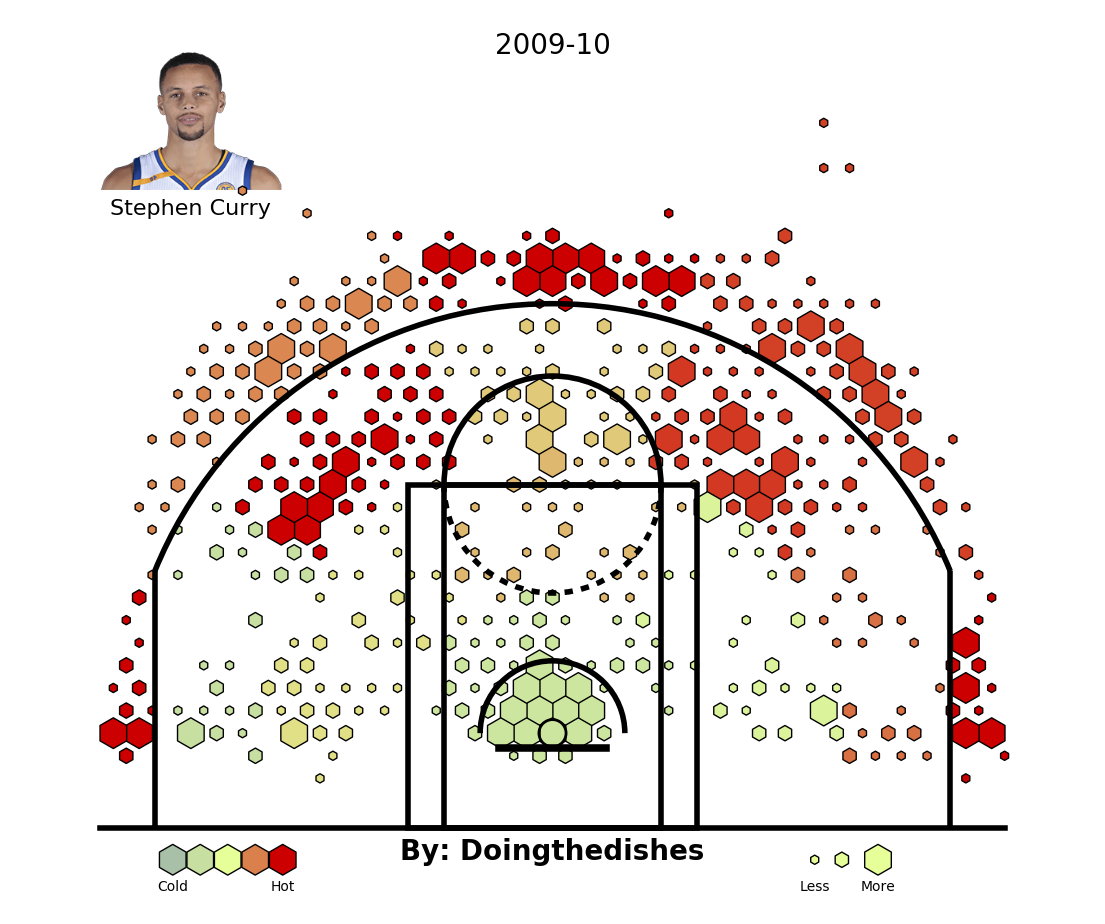

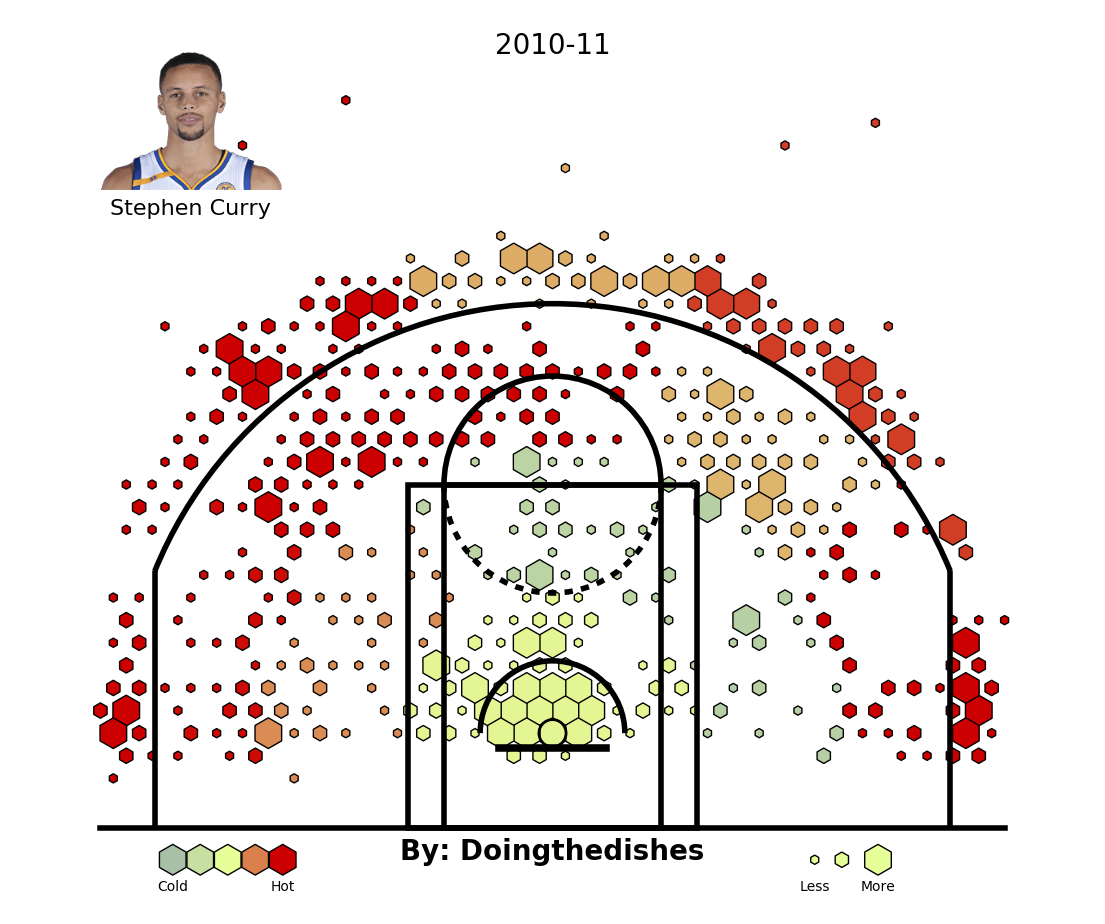

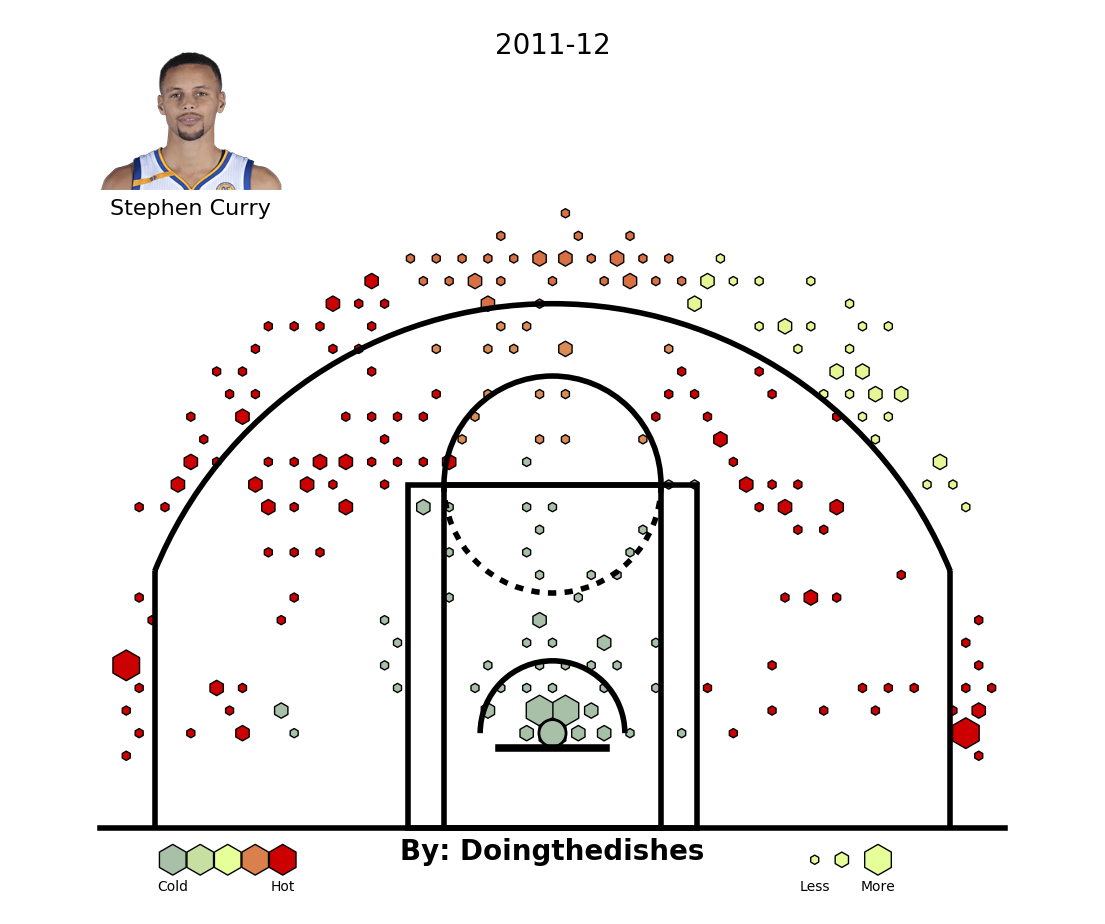

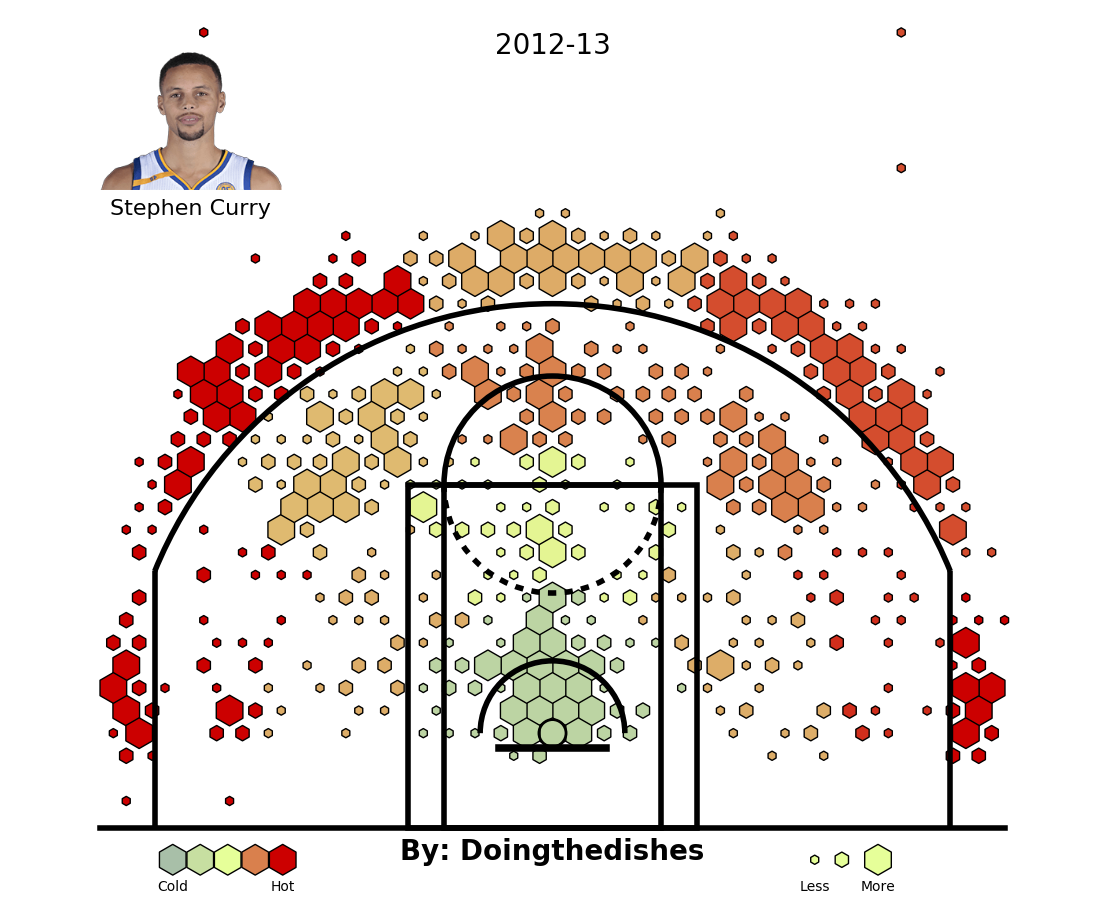

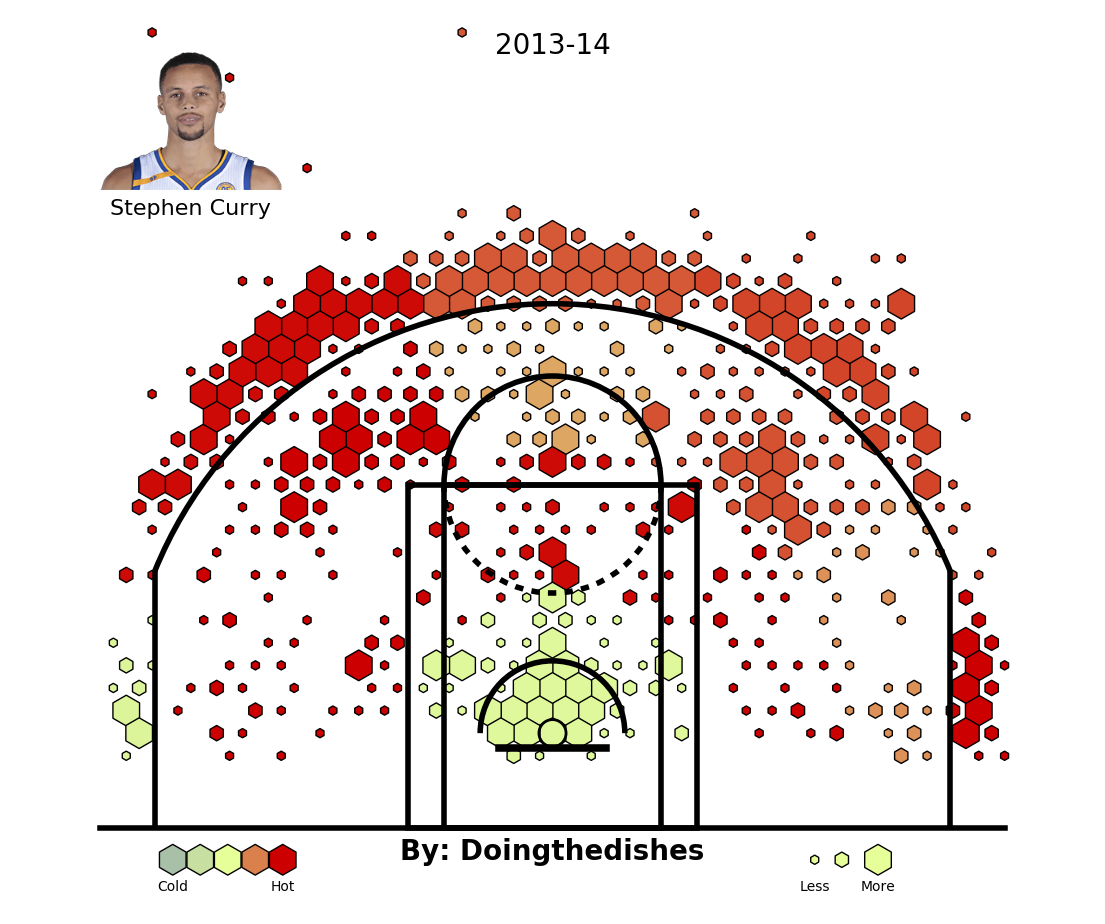

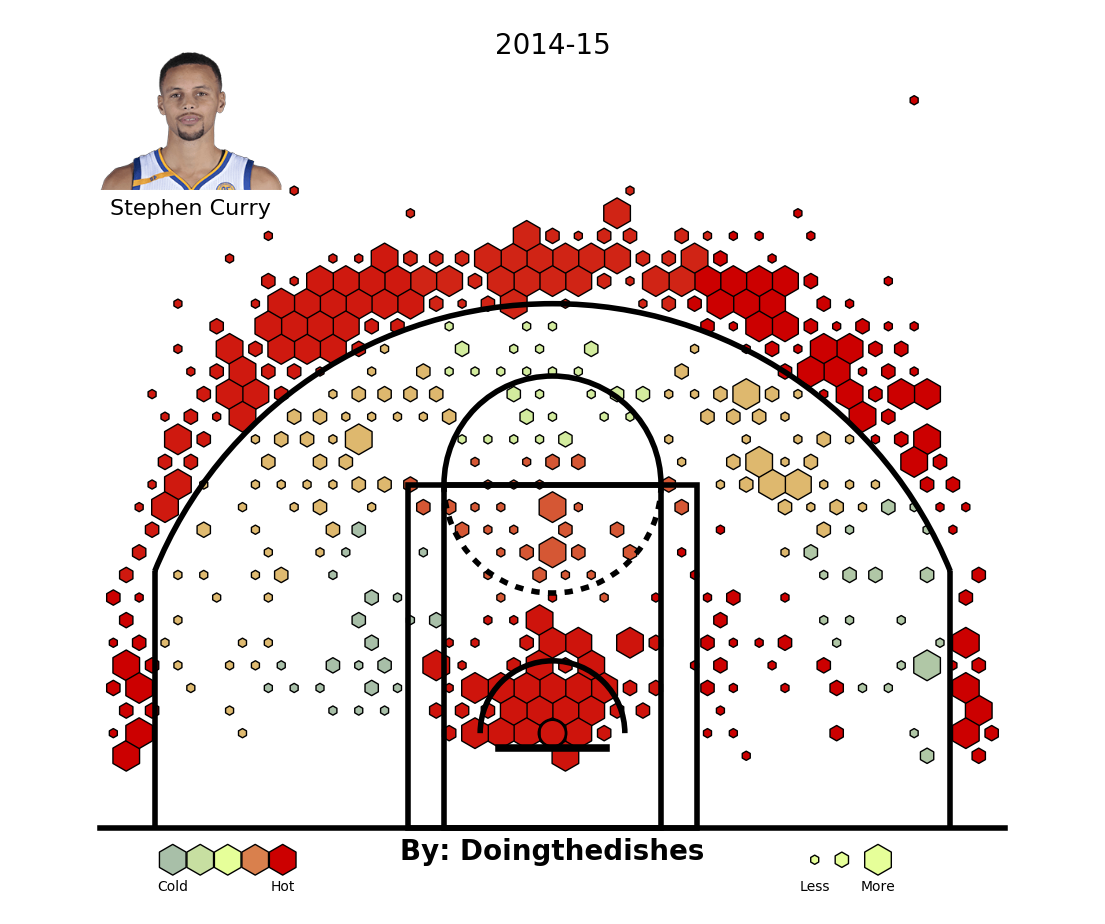

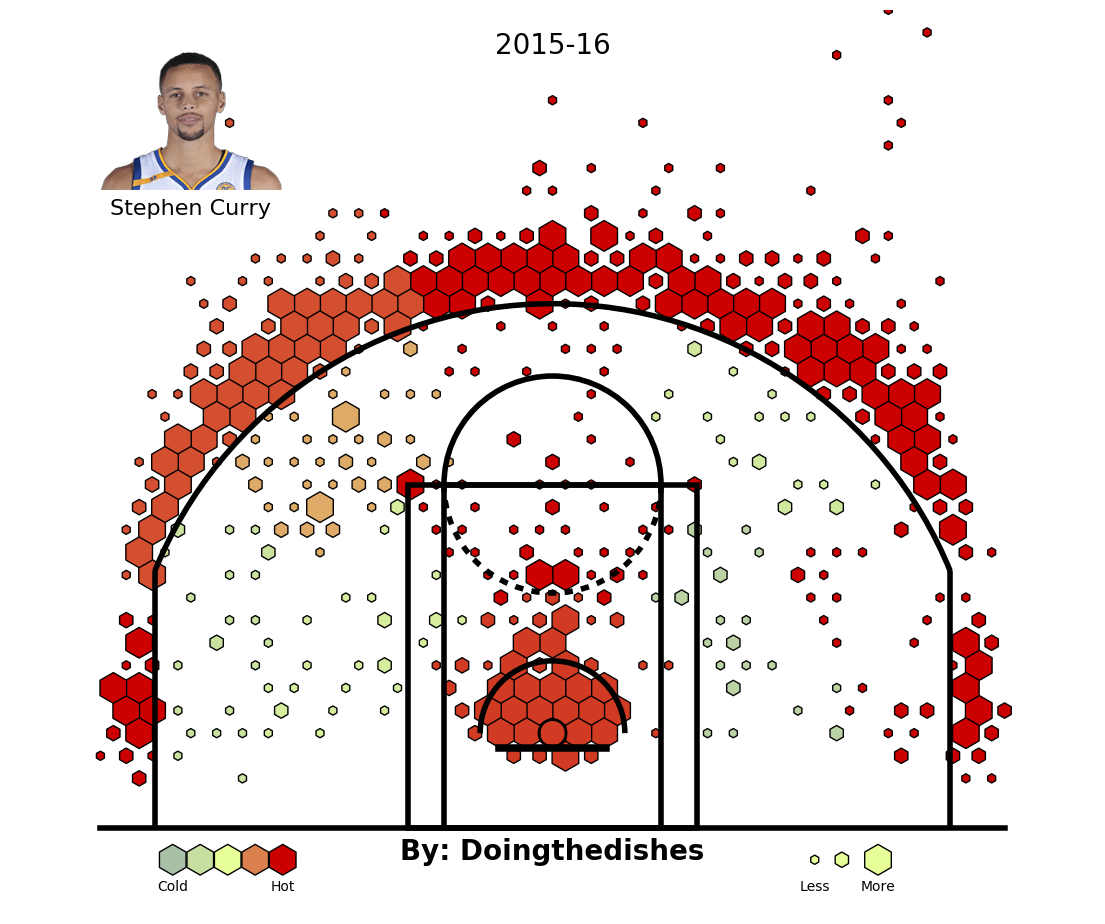

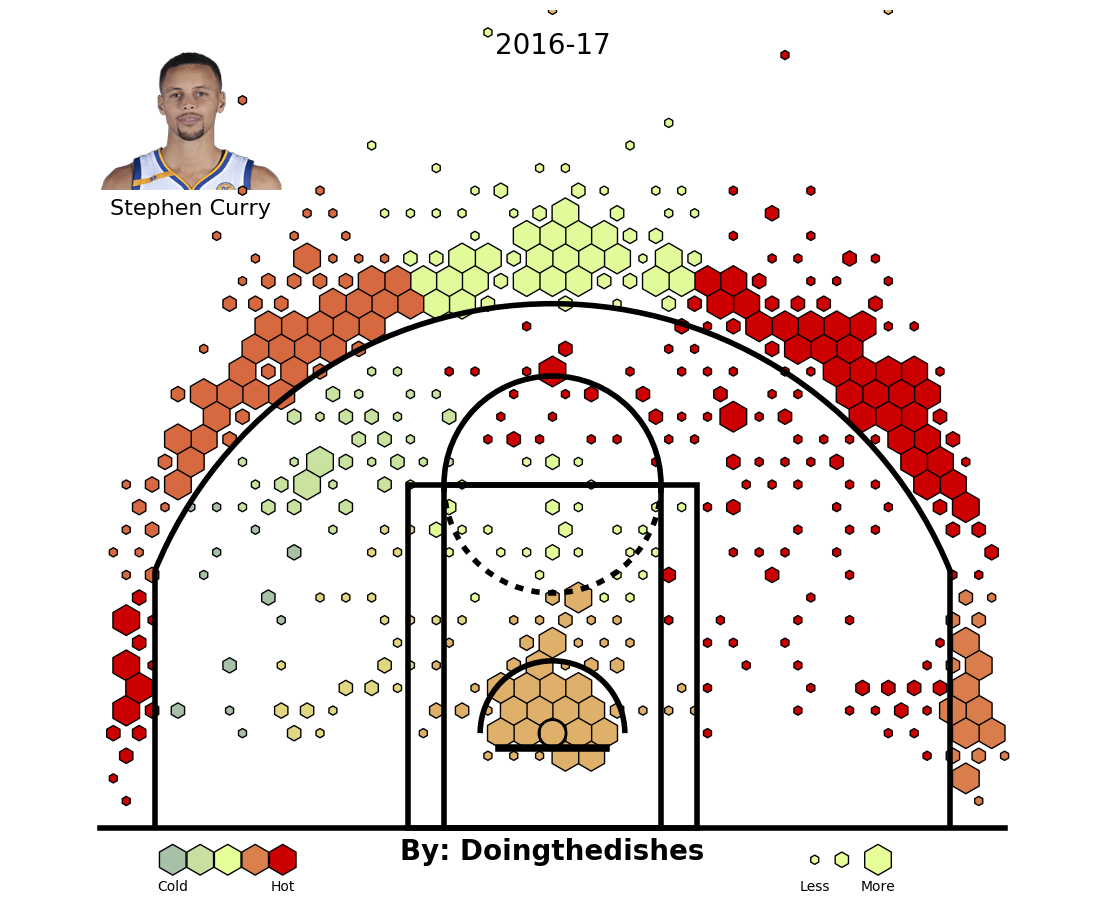

In [12]:
for Season in seasons:
        shotchart,leagueavergae = nba.shotchart.shotchartdetail(playerid=player_id,season=Season) # get shot chart data from NBA.stats
        nba.plot.grantland_shotchart(shotchart,leagueavergae)
        plt.text(0,38,Season,fontsize=20,horizontalalignment='center',verticalalignment='center')

### Let me know what you think

Reference:
1. http://grantland.com/contributors/kirk-goldsberry/
2. https://github.com/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Index.ipynb